# This Notebook

In this Notebook, we will explore the use of LSTM cells to classify sentiment in the Twitter Sentiment140 dataset.

In [1]:
%matplotlib inline


In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8640456232148665661, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4939461427
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17367101724956493339
 physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [3]:
import os
import pandas as pd

cwd = os.getcwd()
fname = f"{cwd}\\trainingandtestdata\\training.1600000.processed.noemoticon.csv"

cols = ['sentiment','id','date','query_string','user','text']
df = pd.read_csv(fname, 
                 header=None, 
                 names=cols, 
                 encoding="latin-1")

df.head(5)


,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.sentiment.value_counts()


4    800000
0    800000
Name: sentiment, dtype: int64

In [5]:
df["target"] = df.sentiment.apply(lambda x: 1 if x > 0 else 0)


# Detect Language and keep English Only

For simplicity, we will deal with a single language only (although our method is multilingual in principle).

You can download the fastText language identifcation model [here](https://fasttext.cc/docs/en/language-identification.html).

In [6]:
import fasttext

class LanguageDetector(object):
    def __init__(self, fname: str, label: str="__label__"):
        self._model = fasttext.load_model(fname)
        self.label = label
        
    def predict(self, text: str):
        prediction, probability = self._model.predict(text, k=1)
        
        prediction = prediction[0].replace(self.label, "")
        probability = probability[0]
        
        return prediction, probability

model_fname = "C:\\Users\dsull\Documents\FastText\lid.176.ftz"
lang_detector = LanguageDetector(model_fname)
lang_detector.predict("this is a test")


('en', 0.9818459153175354)

In [7]:
def detect_language(text):
    lang, proba = lang_detector.predict(text)
    if proba > 0.5:
        return lang
    else:
        return None

df["language"] = df.text.apply(detect_language)
df.language.value_counts()


en    1443234
de       5661
es       2079
fr       1650
it       1398
       ...   
hi          1
ug          1
os          1
mt          1
am          1
Name: language, Length: 112, dtype: int64

In [8]:
df_en = df.loc[df.language == "en"]
print(len(df_en))


1443234


# Preprocess Text

In [9]:
import re
from typing import Optional, List

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

PATTERN = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
matcher = re.compile(PATTERN)

def preprocess(text: str, stopwords: List[str] = [], stemmer: SnowballStemmer = None) -> Optional[str]:
    if isinstance(text, str) and len(text) > 0:
        clean_text = matcher.sub(" ", text.lower()).strip()
        
        tokens = []
        for token in clean_text.split():
            if token not in stopwords:
                if stemmer is not None:
                    tokens.append(stemmer.stem(token))
                else:
                    tokens.append(token)
                    
        return " ".join(tokens)
    return None
    

In [10]:
%%time

stopwords = stopwords.words("english")
# stemmer = SnowballStemmer("english")

df_en.text = df_en.text.apply(lambda x: preprocess(x, stopwords=stopwords))


Wall time: 45.2 s


C:\Users\dsull\Anaconda3\envs\tensorflow_gpu\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


# Split Into train/test

In [11]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_en.dropna(), test_size=0.2, random_state=42)

print("Train size:", len(df_train))
print("Test size:", len(df_test))


Train size: 1154587
Test size: 288647


# Tokenize

In [12]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)


Using TensorFlow backend.


Total words 257670


# Pad Sequences

Keras expects input tensors to be the same shape, so we need to pad the input sequences.

In [13]:
import numpy as np

maxlen = -np.inf

for text in df.text:
    if len(text) > maxlen:
        maxlen = len(text)
        
print("maxlen=", maxlen)


maxlen= 374


In [14]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 150

X_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=maxlen, padding="post")
X_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=maxlen, padding="post")


In [15]:
from keras.utils import to_categorical

y_train = to_categorical(df_train.target)
y_test = to_categorical(df_test.target)


# Initialise FastText model and Weights

We convert sequences to embedding vectors using pre-trained fastText models, which can be downloaded [here](https://fasttext.cc/docs/en/crawl-vectors.html). We will initialse the Embedding layer with these weights and prevent further training (transfer learning).

In [16]:
en_model = fasttext.load_model("C:\\Users\dsull\Documents\FastText\cc.en.300.bin")


In [17]:
"""
The Tokenizer reserved the 0th index for <pad>, which we will leave as a vector of zeros.
We have also set the out of vocabulary token to <unk>, which we will initialise with a random vector.
"""
ndim = en_model.get_dimension()

unk_vector = np.random.uniform(low=-1.0, high=1.0, size=(ndim,))
weights = np.zeros((len(tokenizer.index_word)+1, ndim))

for i, word in tokenizer.index_word.items():
    if word == "<unk>":
        weights[i] = unk_vector
    else:
        weights[i] = en_model.get_word_vector(word)
        
print(weights.shape)
        

(257670, 300)


# Build Model

We will build a bi-directional RNN using the cudNN optimiser CuDNNLSTM/CuDNNGRU layers.

In [18]:
from keras.models import Model
from keras.layers import (
    Input, 
    Embedding, 
    Bidirectional, 
    CuDNNLSTM, 
    SpatialDropout1D, 
    Dropout, 
    Dense
)


In [19]:
# Implement weighted Attention mechanism
from keras.layers import Layer

from keras import backend as K
from keras import initializers

class Attention(Layer):
    """
    Implements weighted Attention mechanism of:
    Zhou, Peng, Wei Shi, Jun Tian, Zhenyu Qi, Bingchen Li, Hongwei Hao and Bo Xu.
    “Attention-Based Bidirectional Long Short-Term Memory Networks for Relation Classification.”
    ACL (2016). http://www.aclweb.org/anthology/P16-2034
    """

    def __init__(self, use_bias=True, return_attention=False, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True
        self.use_bias = use_bias
        self.return_attention = return_attention
        self.W, self.b = None, None

    def get_config(self):
        config = {
            'use_bias': self.use_bias,
            'return_attention': self.return_attention,
        }
        base_config = super(Attention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.W = self.add_weight(shape=(int(input_shape[2]), 1),
                                 name='{}_W'.format(self.name),
                                 initializer=initializers.get('uniform'))
        if self.use_bias:
            self.b = self.add_weight(shape=(1,),
                                     name='{}_b'.format(self.name),
                                     initializer=initializers.get('zeros'))
            
        # Call super last
        super(Attention, self).build(input_shape)

    def call(self, x, mask=None):
        """
        Parameters:
        x - Outputs of Bidirectional LSTM
        """
        logits = K.dot(x, self.W)
        if self.use_bias:
            logits += self.b
            
        x_shape = K.shape(x)
        logits = K.reshape(logits, (x_shape[0], x_shape[1]))
        
        alpha = K.exp(logits - K.max(logits, axis=-1, keepdims=True))
        
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            alpha *= mask
            
        att_weights = alpha / (K.sum(alpha, axis=1, keepdims=True) + K.epsilon())  # softmax
        
        weighted_input = x * K.expand_dims(att_weights)
        r = K.sum(weighted_input, axis=1)  # r = h*alpha^T
        
        h_star = K.tanh(r)
        if self.return_attention:
            return [h_star, att_weights]
        return h_star

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return input_shape[0], output_len

    def compute_mask(self, _, input_mask=None):
        if self.return_attention:
            return [None, None]
        return None

    @staticmethod
    def get_custom_objects():
        return {'Attention': Attention}
        

In [20]:
def build_model(params: dict):
    inputs = Input(shape=(params["maxlen"],))
    
    embedding_weights = params["weights"]
    embeddings_layer = Embedding(input_dim=embedding_weights.shape[0], 
                          output_dim=embedding_weights.shape[1], 
                          weights=[embedding_weights], 
                          trainable=False)

    embeddings = embeddings_layer(inputs)

    # Add SpatialDropout1D
    x = SpatialDropout1D(params["spatial_dropout"])(embeddings)

    # Use single CuDNNLSTM layer
    lstm = CuDNNLSTM(params["lstm_state_size"], return_sequences=True)
    x = Bidirectional(lstm)(x)
    
    # Attention
    x, attn = Attention(return_attention=True)(x)
    
    # Build fully-connected classifier
    x = Dense(params["dense_1"], activation=params["dense_activation"])(x)
    
    # Add dropout
    x = Dropout(params["dropout"])(x)
    
    outputs = Dense(params["num_classes"], activation="softmax")(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    lr = params["lr"]
    optimizer = params["optimizer"]
    opt = optimizer(lr=lr)
    
    loss = "binary_crossentropy"
    if params["num_classes"] > 2:
        loss = "categorical_crossentropy"
        
    model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])
    return model


In [21]:
from keras import backend as K
from keras.optimizers import RMSprop

params = {
    "maxlen": maxlen,
    "weights": weights,
    "spatial_dropout": 0.2,
    "num_lstm": 3,
    "lstm_state_size": 100,
    "dropout": 0.5,
    "dense_1": 128,
    "dense_activation": "relu",
    "num_classes": 2,
    "lr": 1e-3,
    "optimizer": RMSprop  # known good optimizer for RNNs
}

K.clear_session()

model = build_model(params)
model.summary()


W0903 19:52:54.619923  6200 deprecation_wrapper.py:119] From C:\Users\dsull\Anaconda3\envs\tensorflow_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:107: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0903 19:52:54.719187  6200 deprecation_wrapper.py:119] From C:\Users\dsull\Anaconda3\envs\tensorflow_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:111: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0903 19:52:54.764307  6200 deprecation_wrapper.py:119] From C:\Users\dsull\Anaconda3\envs\tensorflow_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0903 19:52:54.766813  6200 deprecation_wrapper.py:119] From C:\Users\dsull\Anaconda3\envs\tensorflow_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is depre

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 300)          77301000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 150, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 200)          321600    
_________________________________________________________________
attention_1 (Attention)      [(None, 200), (None, 150) 201       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               25728     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0   

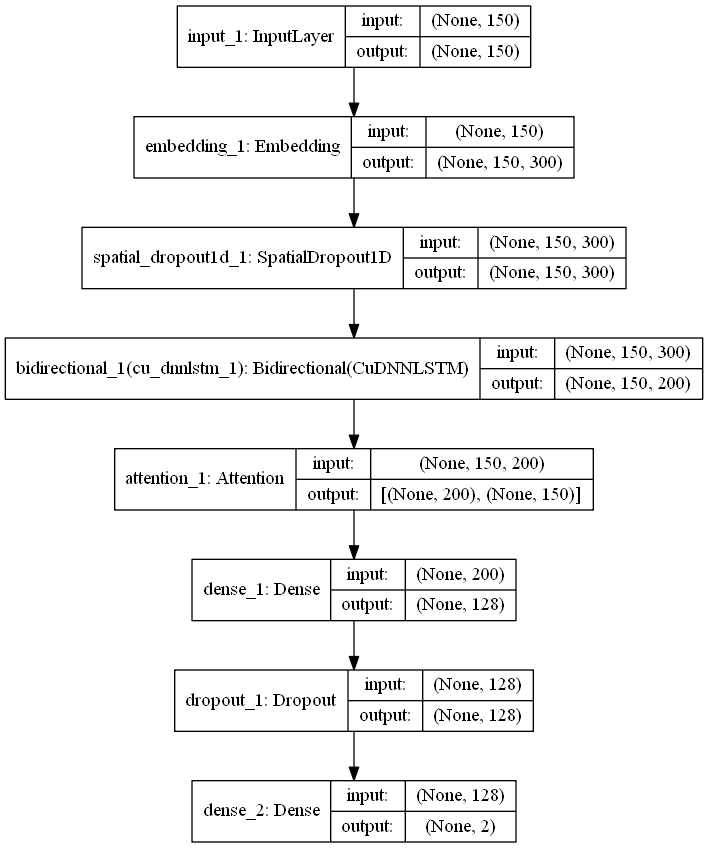

In [22]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)


In [23]:
from keras.models import load_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor="val_acc",
                     min_delta=0.005,
                     patience=3,
                     factor=0.5),
    EarlyStopping(monitor="val_loss",
                 min_delta=0.005,
                 patience=3,
                 mode="auto",
                 restore_best_weights = True)
]

epochs = 10
batch_size = 256

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_test, y_test), callbacks=callbacks)


Train on 1154587 samples, validate on 288647 samples
Epoch 1/10
1154587/1154587 [==============================] - 292s 252us/step - loss: 0.5261 - acc: 0.7363 - val_loss: 0.5157 - val_acc: 0.7456
Epoch 2/10
1154587/1154587 [==============================] - 287s 248us/step - loss: 0.4836 - acc: 0.7668 - val_loss: 0.4859 - val_acc: 0.7664
Epoch 3/10
1154587/1154587 [==============================] - 279s 242us/step - loss: 0.4682 - acc: 0.7766 - val_loss: 0.4695 - val_acc: 0.7726
Epoch 4/10
1154587/1154587 [==============================] - 281s 244us/step - loss: 0.4580 - acc: 0.7833 - val_loss: 0.4669 - val_acc: 0.7749
Epoch 5/10
1154587/1154587 [==============================] - 280s 243us/step - loss: 0.4518 - acc: 0.7868 - val_loss: 0.4578 - val_acc: 0.7793
Epoch 6/10
1154587/1154587 [==============================] - 280s 242us/step - loss: 0.4448 - acc: 0.7914 - val_loss: 0.4676 - val_acc: 0.7775
Epoch 7/10
1154587/1154587 [==============================] - 283s 245us/step - los

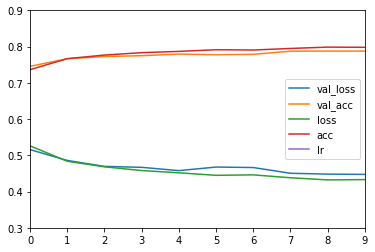

In [24]:
import matplotlib.pylab as plt

historydf = pd.DataFrame(history.history, index=history.epoch)

historydf.plot(ylim=(0.3,0.9))
plt.show()


In [25]:
from sklearn.metrics import accuracy_score

y_train_pred = np.argmax(model.predict(X_train), axis=1)
y_test_pred = np.argmax(model.predict(X_test), axis=1)

print("The Accuracy score on the Train set is:\t{:0.3f}".format(accuracy_score(np.argmax(y_train, axis=1), y_train_pred)))
print("The Accuracy score on the Test set is:\t{:0.3f}".format(accuracy_score(np.argmax(y_test, axis=1), y_test_pred)))


The Accuracy score on the Train set is:	0.809
The Accuracy score on the Test set is:	0.788


In [26]:
from sklearn.metrics import classification_report

y_test_class = np.argmax(y_test, axis=1)
print(classification_report(y_test_class, y_test_pred))


              precision    recall  f1-score   support

           0       0.79      0.80      0.79    147310
           1       0.79      0.78      0.78    141337

    accuracy                           0.79    288647
   macro avg       0.79      0.79      0.79    288647
weighted avg       0.79      0.79      0.79    288647



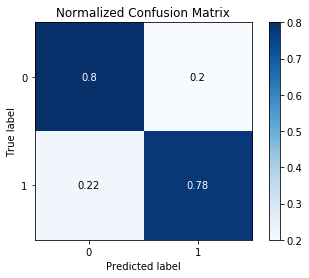

In [27]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_test_class, y_test_pred, normalize=True)
plt.show()


In [28]:
model.layers


In [29]:
att_model_output = model.layers[:-3]
att_model = Model(att_model_output[0].input, att_model_output[-1].output)
att_model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 300)          77301000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 150, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 200)          321600    
_________________________________________________________________
attention_1 (Attention)      [(None, 200), (None, 150) 201       
Total params: 77,622,801
Trainable params: 321,801
Non-trainable params: 77,301,000
_________________________________________________________________


(150, 1)


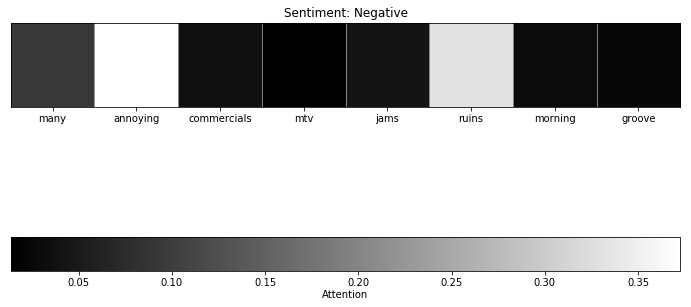

In [114]:
import matplotlib.pylab as plt

def plot_attention(att_model, input_sequences, label, idx2word, ax=None):
    att_map = att_model.predict(np.array([input_sequences]))[1]
    
    idx = np.where(input_sequences > 3)[0]
    labels = [idx2word.get(ix) for ix in input_sequences[idx]]
    activation_map = np.expand_dims(att_map[0][:len(input_sequences)], axis=1)
    print(activation_map.shape)
    
    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 12))
    else:
        fig = plt.gcf()
    ax.set_title("Sentiment: {}".format("Positive" if label == 1 else "Negative"))

    img = ax.imshow(activation_map[idx, :].T, interpolation='none', cmap='gray')

    ax.get_yaxis().set_visible(False)
    
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)

    # Add separator lines
    for y in range(len(labels)):
        ax.axvline(y+0.5, color="w", linestyle="-", lw=0.5)

    cbar = fig.colorbar(img, orientation='horizontal', pad=0.2)
    cbar.ax.set_xlabel('Attention', labelpad=2)
    
    return ax
    
i = 33
plot_attention(att_model, X_train[i], np.argmax(y_train[i]), tokenizer.index_word)
plt.show()
